# Load

In [ ]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
# print("TensorFlow version:", tf.__version__)
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [ ]:
import sys
sys.path.append('drive/MyDrive/MT_ML_Decoding/CNN/load/code')
from load_data import load_MEG_dataset
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

## Load data

In [ ]:
# X, y = load_MEG_dataset([str(i).zfill(3) for i in range(1,5)])
X_train, y_train = load_MEG_dataset([str(i).zfill(3) for i in range(1,3)], mode = 'concatenate', training =True, output_format='numpy')
X_test, y_test = load_MEG_dataset([str(i).zfill(3) for i in range(1,3)], mode = 'concatenate', training =False, output_format='numpy')
X_train, X_test, y_train, y_test = np.array(X_train, dtype=np.float32),\
                                   np.array(X_test, dtype=np.float32),\
                                   np.array(y_train, dtype=np.float32),\
                                   np.array(y_test, dtype=np.float32)
X_train, X_test = (X_train-X_train.mean())/X_train.std(), (X_test-X_test.mean())/X_test.std()
print('loading done.')

Loading subject 001
Data loaded
Subject 001 complete
--------------------------------------
Loading subject 002
Data loaded
Subject 002 complete
--------------------------------------
Loading subject 001
Data loaded
Subject 001 complete
--------------------------------------
Loading subject 002
Data loaded
Subject 002 complete
--------------------------------------
loading done.


In [ ]:
# #batch and shuffle
# train_ds = tf.data.Dataset.from_tensor_slices(
#     (X_train, y_train)).shuffle(10000).batch(32)

# test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

# CNN

In [ ]:
(X0_train, y0_train), (X0_test, y0_test) = tf.keras.datasets.cifar10.load_data()
X0_train.shape

(50000, 32, 32, 3)

In [ ]:
print(X_train.shape, X_test.shape)

(1350, 17, 16, 11) (450, 17, 16, 11)


In [ ]:
X_train = X_train.reshape(1350, 17, 16, 11) #*272 68*4 17*16
X_test = X_test.reshape(450, 17, 16, 11)

In [ ]:
print(X_train.shape, X_test.shape)

(1350, 17, 16, 11) (450, 17, 16, 11)


In [ ]:
model = tf.keras.Sequential(
    [
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation="relu",input_shape=(17, 16, 11)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    # tf.keras.layers.BatchNormalization(),     # do not use together with dropout
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation="softmax")
]
)

In [ ]:
model.summary()
# tf.keras.utils.plot_model(
#     model,
#     to_file="model.png",
#     show_shapes=True,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=True,
#     dpi=96,
# )

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 17, 16, 32)        3200      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 100)              

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Stop at right time

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
callbacks = [
             EarlyStopping(patience=2)
]

save the best model

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='loss',
    mode='min',
    save_best_only=True)
# callback
# callbacks = [
#              EarlyStopping(patience=2),
#              model_checkpoint_callback,
# ]
# another_saved_model = tf.keras.models.load_model(checkpoint_filepath)

Training

In [ ]:
history = model.fit(X_train,y_train, epochs=600,validation_data=(X_test,y_test),callbacks=callbacks)

Epoch 1/600
43/43 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/600
43/43 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00


In [ ]:
import pandas as pd
metrics_df = pd.DataFrame(history.history)

In [ ]:
metrics_df[["loss","val_loss"]].plot();
metrics_df[["accuracy","val_accuracy"]].plot();

# CNN 2 

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(17,16,11)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
model = Sequential([
    data_augmentation,
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(1, activation='softmax')
])

ValueError: ignored

In [ ]:
model.compile(optimizer='adam',
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
history = model.fit(X_train,y_train, epochs=600,validation_data=(X_test,y_test),callbacks=callbacks)

In [ ]:
import pandas as pd

metrics_df = pd.DataFrame(history.history)

In [ ]:
metrics_df[["loss","val_loss"]].plot();

In [ ]:
metrics_df[["binary_accuracy","val_binary_accuracy"]].plot();

In [ ]:
loss, accuracy = model.evaluate(validation_set)
print('Accuracy on test dataset:', accuracy)

test


In [ ]:
prediction = model.predict(X_test,y_test)

# CNN 3


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

(1350, 272, 11)
(1350,)


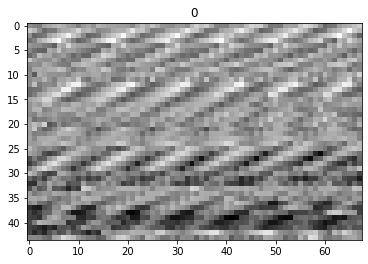

In [ ]:
tf.random.set_seed(1)
np.random.seed(1)

BATCH_SIZE = 50
LR = 0.001              # learning rate

test_x = X_test
test_y = y_test

# plot one example
print(X_train.shape)
print(y_train.shape)
plt.imshow(X_train[0].reshape((44, 68)), cmap='gray') #748*4 187*16 11*16*17 44*68
plt.title('%i' % np.argmax(y_train[0])); plt.show()

In [ ]:
# tf_x = tf.compat.v1.placeholder(tf.float32, [None, 28*28]) / 255.
# image = tf.reshape(tf_x, [-1, 28, 28, 1])              # (batch, height, width, channel)
# tf_y = tf.compat.v1.placeholder(tf.int32, [None, 10])            # input y

# CNN
conv1 = tf.keras.layers.conv2d(   # shape (28, 28, 1)
    inputs=image,
    filters=16,
    kernel_size=5,
    strides=1,
    padding='same',
    activation=tf.nn.relu
)           # -> (28, 28, 16)
pool1 = tf.keras.layers.max_pooling2d(
    conv1,
    pool_size=2,
    strides=2,
)           # -> (14, 14, 16)
conv2 = tf.keras.layers.conv2d(pool1, 32, 5, 1, 'same', activation=tf.nn.relu)    # -> (14, 14, 32)
pool2 = tf.keras.layers.max_pooling2d(conv2, 2, 2)    # -> (7, 7, 32)
flat = tf.reshape(pool2, [-1, 7*7*32])          # -> (7*7*32, )
output = tf.keras.layers.dense(flat, 10)              # output layer

loss = tf.losses.softmax_cross_entropy(onehot_labels=tf_y, logits=output)           # compute cost
train_op = tf.optimizers.Adam(LR).minimize(loss)

accuracy = tf.metrics.accuracy(          # return (acc, update_op), and create 2 local variables
    labels=tf.argmax(tf_y, axis=1), predictions=tf.argmax(output, axis=1),)[1]

# sess = tf.Session()
# init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer()) # the local var is for accuracy_op
# sess.run(init_op)     # initialize var in graph

# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('\nPlease install sklearn for layer visualization\n')
def plot_with_labels(lowDWeights, labels):
    plt.cla(); X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

plt.ion()
for step in range(600):
    b_x, b_y = mnist.train.next_batch(BATCH_SIZE)
    # _, loss_ = sess.run([train_op, loss], {tf_x: b_x, tf_y: b_y})
    _, loss_ = sess.run([train_op, loss], {b_x, b_y})
    if step % 50 == 0:
        # accuracy_, flat_representation = sess.run([accuracy, flat], {tf_x: test_x, tf_y: test_y})
        accuracy_, flat_representation = sess.run([accuracy, flat], { test_x, test_y})        
        print('Step:', step, '| train loss: %.4f' % loss_, '| test accuracy: %.2f' % accuracy_)

        if HAS_SK:
            # Visualization of trained flatten layer (T-SNE)
            tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000); plot_only = 500
            low_dim_embs = tsne.fit_transform(flat_representation[:plot_only, :])
            labels = np.argmax(test_y, axis=1)[:plot_only]; plot_with_labels(low_dim_embs, labels)
plt.ioff()

# print 10 predictions from test data
# test_output = sess.run(output, {tf_x: test_x[:10]})
test_output = sess.run(output, {test_x[:10]})
pred_y = np.argmax(test_output, 1)
print(pred_y, 'prediction number')
print(np.argmax(test_y[:10], 1), 'real number')

RuntimeError: ignored

# CNN 4

In [ ]:
X_train = X_train.reshape(1350, 17, 16, 11) #*272 68*4 17*16
X_test = X_test.reshape(450, 17, 16, 11)

In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow
print(tensorflow.__version__)

2.8.0


## model

In [ ]:
model = tf.keras.Sequential(
    [
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation="relu",input_shape=(17, 16, 11)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Flatten(),
    # tf.keras.layers.Linear(100, activation="relu"),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(28, activation="softmax"),
     
    # tf.keras.layers.Lambda(lambda x: tf.cast(tf.math.argmax(x), dtype='float32'), name='y_pred')
    # tf.keras.layers.Lambda(lambda x: tf.math.argmax(x), name='y_pred')
]
)

model = tf.keras.Sequential(
    [tf.keras.layers.Conv2D(3, (3,3), padding='same', activation="relu",input_shape=(17, 16, 11)),

      tf.keras.applications.resnet50.ResNet50(
      include_top=True,
      weights=None,
      classes=28
      )
    ]
)
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_62 (Conv2D)          (None, 17, 16, 3)         300       
                                                                 
 resnet50 (Functional)       (None, 28)                23645084  
                                                                 
Total params: 23,645,384
Trainable params: 23,592,264
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              
              metrics=['accuracy'])

In [ ]:
# model = tf.keras.applications.resnet50.ResNet50(
#     include_top=True,
#     weights=None,
#     classes=28
# )

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
callbacks = [
             EarlyStopping(patience=2)
]
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='loss',
    mode='min',
    save_best_only=True)
callbacks = [
             EarlyStopping(patience=2),
             model_checkpoint_callback,
]

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1350, 17, 16, 11) (450, 17, 16, 11) (1350, 28) (450, 28)


In [ ]:
_x = tf.keras.applications.resnet.preprocess_input(X_train)

In [ ]:
y_train = tf.one_hot(y_train,28)
y_test = tf.one_hot(y_test,28)

InvalidArgumentError: ignored

In [ ]:
# history = model.fit(X_train,y_train, epochs=1350,validation_data=(X_test,y_test),callbacks=callbacks)
history = model.fit(X_train,y_train, epochs=10,validation_data=(X_test,y_test))

Epoch 1/10


ValueError: ignored

In [ ]:
import pandas as pd
metrics_df = pd.DataFrame(history.history)
metrics_df[["loss","val_loss"]].plot();
metrics_df[["accuracy","val_accuracy"]].plot();